# Анализ поведения пользователей в мобильном приложении
## Описание проекта
Я работаю аналитиком в стартапе, занимающимся продуктами питания. Мне необходимо проверить поведение пользователей в мобильном приложении. 

### Цели проекта
Необходимо изучить воронку продаж, посмотреть где и сколько пользователей застревает, сколько в итоге доходит до покупки.

После необходимо провести А/А/В-тест по смене шрифта. Две группы будут контрольными, которым не будут менять шрифт, это заодно проверит чистоту нашего эксперимента, а также установить время, после которого можно считать, что эксперимент стабилизировался. 

### Описание данных
Каждая запись в логе — это действие пользователя, или событие.
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Инструкция по выполнению проекта
**1. Открыть файл с данными и изучите общую информацию**


**2. Подготовить данные**
* Заменить названия столбцов на удобные для вас;
* Проверить пропуски и типы данных. Откорректируйте, если нужно;
* Добавить столбец даты и времени, а также отдельный столбец дат;


**3. Изучите и проверьте данные**
* Какое количество событий в логе?
* Какое количество пользователей в логе?
* Какое среднее количество событий приходится на пользователя?
* Данными за какой период у нас имеются? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период, учитывая что в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого. Определить, с какого момента данные полные и отбросьте более старые. Данными за какой период времени у нас есть на самом деле?
* Много ли событий и пользователей вы потеряли, отбросив старые данные?
* Проверить, что у вас есть пользователи из всех трёх экспериментальных групп.


**4. Изучить воронку событий**
* Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.
* Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.
* Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
* По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
* На каком шаге теряется больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?


**5. Изучите результаты эксперимента**
* Сколько пользователей в каждой экспериментальной группе? 
* Проверить, находят ли статистические критерии разницу между выборками 246 и 247.
* Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
* Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
* Какой уровень значимости выбрать при проверке статистических гипотез выше? Посчитать, сколько проверок статистических гипотез было сделано. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

## Открытие файла с данными и первичный анализ
### Импорт библиотек

In [55]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go 
from datetime import datetime
import scipy.stats as stats
import numpy as np
import math as mth

In [56]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков не наблюдается.

## Подготовка данных
### Переименование столбцов
Переведём всё в любимый змеиный регистр

In [57]:
df = df.rename(
    columns = {
        'EventName': 'event_name',
        'DeviceIDHash': 'user_id',
        'EventTimestamp': 'event_ts',
        'ExpId': 'exp_id'
    }
)
df.head()

,event_name,user_id,event_ts,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Проверка на дубликаты
Сперва надо проверить всё на явные дубликаты

In [58]:
df.duplicated().value_counts()

False    243713
True        413
dtype: int64

В датафрейме имеются 413 дубликатов. Поскольку один пользователь в один и тот же момент не мог совершить дважды одно и то же действие, то эти повторы смело сносим.

In [59]:
df = df.drop_duplicates(keep='first', ignore_index = True)

### Изменение типа данных
Все данные у нас ок, кроме данных с временем событий, поэтому переведём его в соответствующий формат.

In [60]:
df['event_ts'] = pd.to_datetime(df['event_ts'], unit='s')

Добавим отдельный столбец с датой по всем событиям.

In [61]:
df['date'] = df['event_ts'].dt.floor('1D')

## Изучение данных
### Количество событий, пользователей, среднее количество событий
Посчитаем количество всех событий, уникальных пользователей и среднее количество событий на каждого пользователя, определив их соотношение.

In [62]:
n_events = df['event_name'].count()
n_users = df['user_id'].nunique()
avg_events = n_events / n_users
display(f'Всего зафиксировано {n_events} событий. Приняло участие в эксперименте {n_users} пользователей.')
display(f'В среднем на каждого пользователя пришлось {round(avg_events, 2)} событий.')

'Всего зафиксировано 243713 событий. Приняло участие в эксперименте 7551 пользователей.'

'В среднем на каждого пользователя пришлось 32.28 событий.'

### Период проведения эксперимента
Выведем крайние точки наших дат.

In [63]:
df['date'].dt.date.min(), df['date'].dt.date.max()

(datetime.date(2019, 7, 25), datetime.date(2019, 8, 7))

Эксперимент проводился с 25 июля по 7 августа 2019 г.

Теперь построим частотную гистограмму с количеством событий в единицу времени и сравним, везде ли плотность событий у нас одинакова.

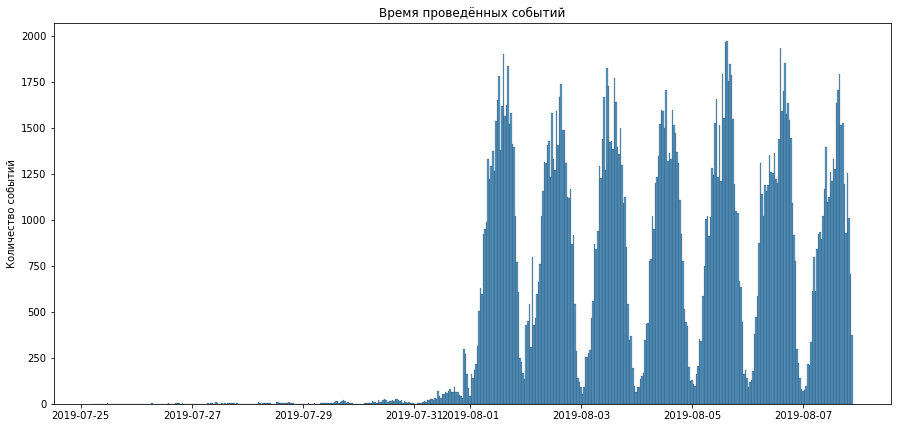

In [64]:
plt.figure(figsize=(15,7))
sns.histplot(df['event_ts'], bins=500)
plt.title('Время проведённых событий')
plt.ylabel('Количество событий')
plt.xlabel('')
plt.show()

### Фильтрация данных по дате

Из графика видно, что фактически данные у нас "пошли" только с 1 августа. Всё, что происходило в июле - остаётся в июле. Фактически у нас есть данные за первую августовскую неделю. Оставим датафрейм за интересующий нас период.

In [65]:
df = df[df['date'] >= '2019-08-01']

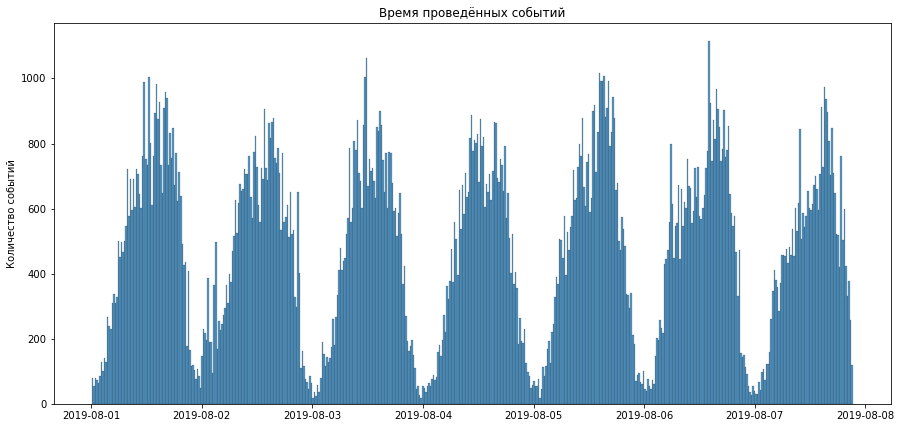

In [66]:
plt.figure(figsize=(15,7))
sns.histplot(df['event_ts'], bins=500)
plt.title('Время проведённых событий')
plt.ylabel('Количество событий')
plt.xlabel('')
plt.show()

### Оценка потерь данных

Прикинем, сколько мы потеряли пользователей и событий при сносе июльских данных.

In [67]:
n_fresh_events = df['event_name'].count()
n_fresh_users = df['user_id'].nunique()

display(f'Всего потеряли {n_events - n_fresh_events} событий или {1-n_fresh_events/n_events:.2%}.')
display(f'Всего потеряли {n_users - n_fresh_users} пользователей или {1-n_fresh_users/n_users:.2%}.')

'Всего потеряли 2826 событий или 1.16%.'

'Всего потеряли 17 пользователей или 0.23%.'

Несущественные потери. Без них легко переживём.

### Проверка наличия всех групп

Посмотрим как распределены пользователи по группам.

In [68]:
for i in df['exp_id'].unique():
    group_users = df[df['exp_id']==i]['user_id'].nunique()
    display(f'В {i} категории {group_users} пользователей')

'В 246 категории 2484 пользователей'

'В 247 категории 2513 пользователей'

'В 248 категории 2537 пользователей'

В каждой категории пользователи представлены, причём очень даже равномерно.

## Изучение воронки событий
### Анализ частоты событий
Посчитаем сколько у нас произошло разных событий вообще.

In [69]:
df['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Туториал не входит в основной "маршрут" клиента *(это называется CJM)*, заниамет небольшую часть датафрейма, поэтому мы его смело выпилим.

In [70]:
df = df.query('event_name != "Tutorial"')

### Количество пользователей, совершивих каждое событие

А теперь посчитаем, какое количество уникальных пользователей совершило у нас то или иное действие.

In [71]:
event_users = (df.groupby('event_name')
               .agg({'user_id': 'nunique'})
               .sort_values(by='user_id', ascending=False))
event_users['ratio'] = round(event_users['user_id'] / n_fresh_users * 100, 1)
event_users

,user_id,ratio
event_name,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0


Хм, интересно. У нас есть 1.5% пользователей, которые не вошли в главный экран. Но они же фигурировали где-то, это всё те же пользователи. Значит, что они засветились где-то дальше. Вангую, что это пользователи с июльским бэкграундом, которые чёт посмотрели и заказали в июле, а оплатили уже в августе, с которого мы и начали считать.
### Очерёдность событий
Предположительно, события происходят в следующем порядке: открытие главной страницы - открытие страницы с предложениями - открытие страницы корзины - открытие страницы об успешной оплате.
### Построение воронки
Построим следующую воронку событий: главная страница - страница с предложениями - корзина - оплата.

In [72]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Просмотрели главную страницу',
            'Просмотрели страницу с предложениями',
            'Добавили товар в корзину',
            'Оплатили товар',
        ],
        x=event_users['user_id'],
        textinfo = 'value+percent previous+percent initial'
        
    )
)

fig.update_layout(title='Событийная воронка')
fig.show() 

Как видно из воронки, наибольшая конверсия была на 3 переходе - пользователи добавившие товар в козрину, которые потом его оплатили - 95%. На 2 переходе - пользователи просмотревшие товар, которые потом его добавили - 81%. Хуже всего на 1 переходе - от просмотра главной страницы до выбора товара дошло всего 62%.

От начала и до конца дошло меньше половины - всего 48%.

## Изучение результатов эксперимента
### Количество пользователей в каждой группе
Это мы проводили в п. 3.5, когда проверяли наличие пользователей в каждой группе, но вместе тем, с качественной проверкой была проведена и количественная.
### Проверка результатов А/А-теста
Чтобы проверить результаты А/А-теста, необходимо сравнить две выборки: 246 и 247. Для этого необходимо провести Z-тест. Напишем функцию, которая упростит в будущем подбные обработки, обозначим коэффициент статистической значимости и нулевую и альтернативную гипотезы.

>* H<sub>0</sub> - между исследуемыми долями нет значимых отличий.
>* H<sub>1</sub> - исследуемые доли различны.

In [73]:
alpha = 0.05

In [74]:
# функция для проведения Z-теста (определения z-критерия Фишера)

# вводим номера двух сравниваемых групп, событие, по которому проводится сравнение
# и уровень статистической значимости, ниже которого можно говорить о значимой различности выборок
def z_test(condition_1, condition_2, event, alpha):
    
    # описание одной группы
    df_1 = df.query(condition_1) # датафрейм первой группы
    all_users_1 = df_1['user_id'].nunique() # общее количество пользователей первой группы
    event_users_1 = df_1[df_1['event_name']==event]['user_id'].nunique() # количество пользователей,
                                                                         # совершивших целевое событие
    
    # описание второй группы
    df_2 = df.query(condition_2) # датафрейм второй группы
    all_users_2 = df_2['user_id'].nunique() # общее количество пользователей второй группы
    event_users_2 = df_2[df_2['event_name']==event]['user_id'].nunique() # количество пользователей,
                                                                         # совершивших целевое событие
    
    # уровень статистической значимости
    alpha = alpha
    
    # конверсии двух выборок
    p1 = event_users_1 / all_users_1
    p2 = event_users_2 / all_users_2
    
    # общая конверсия
    p_combined = (event_users_1 + event_users_2) / (all_users_1 + all_users_2)
    
    # разница конверсий
    delta = p1 - p2
    
    # z-критерий
    z_value = delta / mth.sqrt(p_combined * (1 - p_combined) * (1/all_users_1 + 1/all_users_2))
    
    # нормальное распределение: среднее в нуле, а стандартное отклонение - 1
    distr = stats.norm(0, 1)
    
    # подсчёт статистической значимости
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        display('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
        
z_test('exp_id == 246', 'exp_id == 247', event_users.index[0], alpha)

p-значение:  0.7526703436483038


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

Уровень статистической значимости достаточно высок, чтобы считать, что отстутствуют основания счиать  две группы А различными. А значит, А/А-тест прошёл корректно.

### Сравнение групп
Подготовим данные отдельно по каждой группе и построим для них одну большую воронку. Так мы сможем наглядно увидеть число пользователей в каждой группе, совершивших интересующее нас действие, а также и какой уровень конверсии был на каждом шаге.

In [75]:
event_users_246 = (df.query('exp_id == 246').groupby('event_name')
                   .agg({'user_id': 'nunique'})
                   .sort_values(by='user_id', ascending=False))

event_users_247 = (df.query('exp_id == 247').groupby('event_name')
                   .agg({'user_id': 'nunique'})
                   .sort_values(by='user_id', ascending=False))

event_users_248 = (df.query('exp_id == 248').groupby('event_name')
                   .agg({'user_id': 'nunique'})
                   .sort_values(by='user_id', ascending=False))

In [76]:
fig = go.Figure()

funnel_ax = [
    'Просмотрели главную страницу',
    'Просмотрели страницу с товаром',
    'Добавили товар в корзину',
    'Оплатили товар'
]
fig.add_trace(go.Funnel(
    name = '246',
    y=funnel_ax,
    x = event_users_246['user_id'],
    textinfo = 'value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = '247',
    y=funnel_ax,
    x = event_users_247['user_id'],
    textinfo = 'value+percent previous+percent initial'))

fig.add_trace(go.Funnel(
    name = '248',
    y=funnel_ax,
    x = event_users_248['user_id'],
    textinfo = 'value+percent previous+percent initial'))

fig.update_layout(title='Событийная воронка с разбивкой по группам')
fig.show()

Как и раньше, самым популярным событием во всех группах был просмотр главной страницы. Проведём Z-тест и посмотрим, как сильно отличаются группы на первом этапе.

#### Z-тест "просмотр главной страницы"

In [77]:
z_test('exp_id == 246', 'exp_id == 247', event_users.index[0], alpha)
z_test('exp_id == 246', 'exp_id == 248', event_users.index[0], alpha)
z_test('exp_id == 247', 'exp_id == 248', event_users.index[0], alpha)

p-значение:  0.7526703436483038


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.3387114076159288


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.5194964354051703


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

Нет оснований считать доли разными.

Продолжаем тест для просмотра товара.

#### Z-тест "просмотр страницы с товаром"

In [78]:
z_test('exp_id == 246', 'exp_id == 247', event_users.index[1], alpha)
z_test('exp_id == 246', 'exp_id == 248', event_users.index[1], alpha)
z_test('exp_id == 247', 'exp_id == 248', event_users.index[1], alpha)

p-значение:  0.24786096925282264


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.21442476639710506


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.9333751305879443


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

246 отличается больше от 247, чем 247 от 248. Но всё ещё нет оснований считать доли разными.

Продолжаем тест для добавления товара в корзину.

#### Z-тест "добавление товара в корзину"

In [79]:
z_test('exp_id == 246', 'exp_id == 247', event_users.index[2], alpha)
z_test('exp_id == 246', 'exp_id == 248', event_users.index[2], alpha)
z_test('exp_id == 247', 'exp_id == 248', event_users.index[2], alpha)

p-значение:  0.22867643757335676


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.08067367598823139


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.5878284605111943


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

Было близко между 246 и 248, но всё ещё нет оснований считать доли разными.

Продолжаем тест для оплаты товара.

#### Z-тест "оплата товара"

In [80]:
z_test('exp_id == 246', 'exp_id == 247', event_users.index[3], alpha)
z_test('exp_id == 246', 'exp_id == 248', event_users.index[3], alpha)
z_test('exp_id == 247', 'exp_id == 248', event_users.index[3], alpha)

p-значение:  0.11446627829276612


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.21693033984516674


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.7275718682261119


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

С оплатой товара тоже нет статитистических значимых отличий.

Проверим на объединённой контрольной группе.

#### Z-тест по всем событиям (объёдинённая контрольная группа и экспериментальная группа)

In [81]:
# сравним 248 группу и НЕ 248 группу (то есть 246 и 247)
[z_test('exp_id != 248', 'exp_id == 248', i, alpha) for i in event_users.index]

p-значение:  0.3486684291093256


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.44582745409482394


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.18683558686831558


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

p-значение:  0.6107918742187335


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

[None, None, None, None]

Полученные резульататы не позволяют заявить, что группы хоть сколько значимо отличаются.

### Уровень значимости
Уровень статистической значимости — это вероятность случайно получить в реальном наблюдении значение, далёкое от предполагаемого в нулевой гипотезе. Выбранный уровень значимости равен $\alpha$ =  0.05. Это также значит, что вероятность ошибиться и получить ложнопозитивный результат тоже равна 0.05, то есть в одной из двадцати проверок p-value скажет нам, что выборки статистически значимо различаются, хоть это и не так.

Всего мы провели 16 проверок: 4 события, изначальные 3 пары групп, плюс ещё 1 дополнительная - 4 * 4 = 16. Поэтому можно считать, что коэффициент статистической значимости $\alpha$ =  0.05 выбран удачно. Пересчитывать ничего не нужно.

## Выводы и рекомендации
### Выводы
* По итогам выполнения проекта был проведена подговка данных, в ходе которой были выявлены и устранены явные дубликаты. 

* Изначально в нашем распоряжении были данные с 25 июля по 8 августа 2019 г. Однако по результатам оценки частотно-событийной гистограммы было установлено, что актуальными являются данные только с 1 августа, поскольку июльские данные не играют значимой роли в нашем анализе и составляют всего 1.16%.

* Построив событийную воронку по всем пользователям, стало видно, что наименьшая конверсия на переходе от главной страницы к выбору продуктов. Туда доходят всего лишь 62% пользователей. В то время как от выбора товара до корзины доходит 81%, а оплату проводит 95%. Весь путь проходят 48% пользователей.

* При проверке А/А/В-теста, где проверялось влияние изменения шрифта в приложении в группе В, была установлена корректность А/А-теста, который не показал значимых изменений между двумя контрольными группами, где шрифты остались старые. Однако в дальнейшем проверка результатов показала, что какие-либо значимые изменения отсутствуют при сравнении любых групп на всех этапах, что позволяет сделать вывод о том, что изменение шрифтов не оказывает особого влияния.

### Рекомендации
* Рассмотреть процесс перехода между от главной страницы до страницы с продуктами с целью повышения уровня конверсии.

* С учётом полученных результатов в А/А/В-тесте менять шрифты нецелесообразно.